In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Output')

library("readxl")
library(tidyverse)
library(reshape2)

#reading in file
data <- read_excel("CytokineData_081920.xlsx", sheet = 2)
data_df = data.frame(data)

#reading in demographics file
demographics_data_df = data.frame(read_excel("SubjectInfo_081920.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#adding demographics data to cytokine df
#could've made my life easier by just using full_join but didn't need every column from the demographics data set
race = c()
ethnicity = c()
sex = c()
age = c()
BMI = c()
for (i in 1:length(data_df$SubjectNo)){
    for(j in 1:length(demographics_data_df$SubjectNo)){
        if (data_df$SubjectNo[i] == demographics_data_df$SubjectNo[j]){
            race = c(race, demographics_data_df$Race[j])
            ethnicity = c(ethnicity, demographics_data_df$Ethnicity[j])
            sex = c(sex, demographics_data_df$Sex[j])
            age = c(age, demographics_data_df$Age[j])
            BMI = c(BMI, demographics_data_df$BMI[j])
        }
    }
}

data_df$Race = race
data_df$Ethnicity = ethnicity
data_df$Sex = sex
data_df$Age = age
data_df$BMI = BMI

First running "crude" model by running ANOVA to compare cytokine profiles across compartments. Then running ANCOVA to compare cytokine profiles across compartments adjusting for race and sex separately. Z-score normalizing for  cytokines (using pseudolog2 of concentrations).

In [3]:
head(data_df)

,Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID,Race,Ethnicity,Sex,Age,BMI
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,E_C_F_002,IFNg,17.642316,4.220509,ELF,1,NS,NS_1,W,NH,F,28,37.67
2,E_C_F_002,IL10,2.873724,1.953721,ELF,1,NS,NS_1,W,NH,F,28,37.67
3,E_C_F_002,IL12p70,1.625272,1.392467,ELF,1,NS,NS_1,W,NH,F,28,37.67
4,E_C_F_002,IL13,36.117692,5.214035,ELF,1,NS,NS_1,W,NH,F,28,37.67
5,E_C_F_002,IL1b,104.409217,6.719857,ELF,1,NS,NS_1,W,NH,F,28,37.67
6,E_C_F_002,IL6,21.159536,4.469856,ELF,1,NS,NS_1,W,NH,F,28,37.67


In [4]:
#making race binary between black and non- black subjects
for (i in 1:length(data_df$Race)){
    if(data_df$Race[i] != 'AA'){
        data_df$Race[i] = 'NB'
    }
}

In [5]:
#scaling the concentration values by protein within each compartment normalizes the distribution
scaled_data_df = data_df %>%
    #filter(Conc_pslog2 > 0) %>% #removing these values to prevent null scaled values
    group_by(Compartment, Protein) %>% #this groups by compartment first and then proteins within each compartment
    mutate(Scaled_Concentrations = scale(Conc_pslog2)) %>%
    arrange(Compartment, Protein, SubjectID) #arranges by compartment, then protein, then subjectid
head(scaled_data_df)

Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID,Race,Ethnicity,Sex,Age,BMI,Scaled_Concentrations
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,"<dbl[,1]>"
E_A_F_001,Eotaxin,78.86098,6.319419,ELF,15,CS,CS_15,AA,NH,F,34,27.3,-0.4565012
E_A_F_009,Eotaxin,96.76412,6.611233,ELF,16,CS,CS_16,AA,NH,F,33,40.4,-0.2223511
E_A_F_096,Eotaxin,71.50873,6.180083,ELF,17,CS,CS_17,AA,NH,F,24,22.3,-0.5683035
E_A_F_112,Eotaxin,74.90917,6.246202,ELF,18,CS,CS_18,NB,NH,F,33,18.8,-0.5152497
E_A_F_141,Eotaxin,748.69142,9.550153,ELF,19,CS,CS_19,AA,NH,F,29,27.5,2.1358195
E_A_F_30006,Eotaxin,46.64424,5.574230,ELF,20,CS,CS_20,AA,NH,F,25,29.8,-1.0544360


In [6]:
# Check that we now have a mean of ~0 and SD of 1 for each cytokine
NLF_scaled = scaled_data_df %>% filter(Compartment == 'NLF')
NLF_scaled %>%
    group_by(Protein) %>%
    summarize(cytokine_mean = mean(Scaled_Concentrations), cytokine_sd = sd(Scaled_Concentrations))
ELF_scaled = scaled_data_df %>% filter(Compartment == 'ELF')
ELF_scaled %>%
    group_by(Protein) %>%
    summarize(cytokine_mean = mean(Scaled_Concentrations), cytokine_sd = sd(Scaled_Concentrations))
Sputum_scaled = scaled_data_df %>% filter(Compartment == 'Sputum')
Sputum_scaled %>%
    group_by(Protein) %>%
    summarize(cytokine_mean = mean(Scaled_Concentrations), cytokine_sd = sd(Scaled_Concentrations))
Serum_scaled = scaled_data_df %>% filter(Compartment == 'Serum')
Serum_scaled %>%
    group_by(Protein) %>%
    summarize(cytokine_mean = mean(Scaled_Concentrations), cytokine_sd = sd(Scaled_Concentrations))


`summarise()` ungrouping output (override with `.groups` argument)



Protein,cytokine_mean,cytokine_sd
<chr>,<dbl>,<dbl>
Eotaxin,-1.711810e-16,1
Eotaxin3,-7.532624e-17,1
Fractalkine,1.632060e-16,1
I309,NaN,NA
IFNg,-1.631079e-17,1
IL10,-4.400312e-17,1
IL12p70,-8.572941e-18,1
IL13,1.024623e-16,1
IL17B,-1.692411e-16,1


`summarise()` ungrouping output (override with `.groups` argument)



Protein,cytokine_mean,cytokine_sd
<chr>,<dbl>,<dbl>
Eotaxin,7.979728e-17,1
Eotaxin3,-1.837452e-16,1
Fractalkine,7.682831e-17,1
I309,-5.321626e-18,1
IFNg,-1.189751e-16,1
IL10,5.916259e-17,1
IL12p70,-9.099651e-17,1
IL13,-4.376111e-17,1
IL17B,-1.417594e-16,1


`summarise()` ungrouping output (override with `.groups` argument)



Protein,cytokine_mean,cytokine_sd
<chr>,<dbl>,<dbl>
Eotaxin,-3.666152e-17,1
Eotaxin3,-7.073064e-17,1
Fractalkine,-3.436327e-16,1
I309,NaN,NA
IFNg,5.560408e-17,1
IL10,-4.681172e-17,1
IL12p70,-2.846031e-17,1
IL13,8.452840e-17,1
IL17B,1.654473e-17,1


`summarise()` ungrouping output (override with `.groups` argument)



Protein,cytokine_mean,cytokine_sd
<chr>,<dbl>,<dbl>
Eotaxin,2.587371e-16,1
Eotaxin3,-8.962996e-17,1
Fractalkine,6.136991e-16,1
I309,8.570360e-18,1
IFNg,1.489100e-16,1
IL10,-1.064280e-16,1
IL12p70,-1.129532e-16,1
IL13,3.077069e-18,1
IL17B,0.000000e+00,1


## One-way Anova

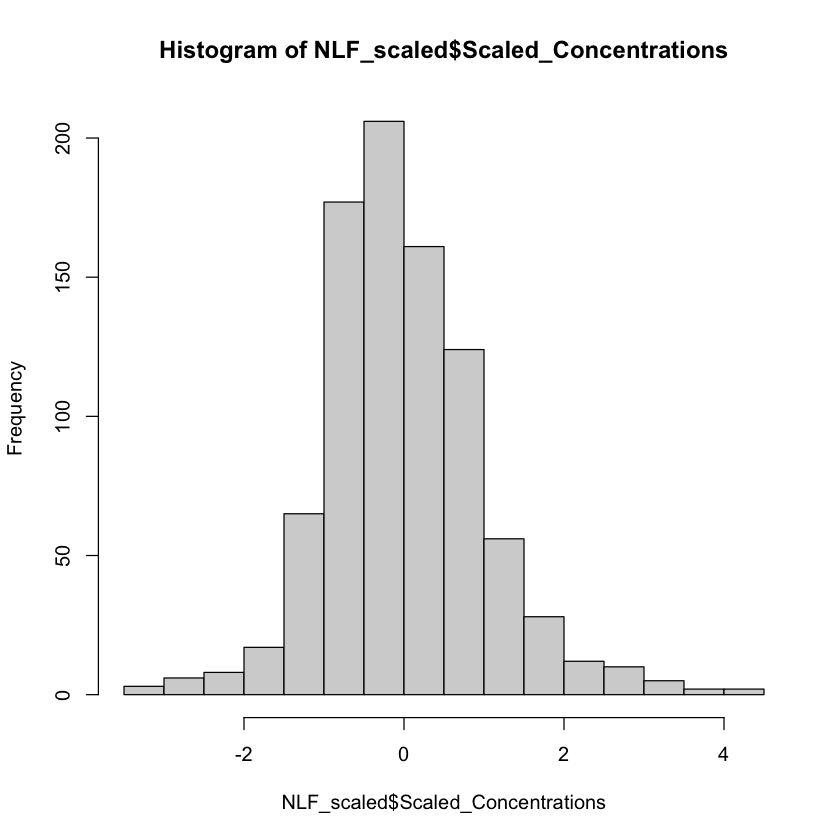

In [7]:
#checking for normal distribution
hist(NLF_scaled$Scaled_Concentrations)

In [8]:
#formatting data to be put into the anova function 
#putting proteins into a factor so anova can read them as categorical
NLF_scaled$Protein = factor(NLF_scaled$Protein, labels = c(unique(NLF_scaled$Protein)))
ELF_scaled$Protein = factor(ELF_scaled$Protein, labels = c(unique(ELF_scaled$Protein)))
Sputum_scaled$Protein = factor(Sputum_scaled$Protein, labels = c(unique(Sputum_scaled$Protein)))
Serum_scaled$Protein = factor(Serum_scaled$Protein, labels = c(unique(Serum_scaled$Protein)))

#concentrations need to be reassigned as numeric
NLF_scaled$Scaled_Concentrations = as.numeric(NLF_scaled$Scaled_Concentrations)
ELF_scaled$Scaled_Concentrations = as.numeric(ELF_scaled$Scaled_Concentrations)
Sputum_scaled$Scaled_Concentrations = as.numeric(Sputum_scaled$Scaled_Concentrations)
Serum_scaled$Scaled_Concentrations = as.numeric(Serum_scaled$Scaled_Concentrations)

In [9]:
summary(aov(Scaled_Concentrations~Protein, data = NLF_scaled))
summary(aov(Scaled_Concentrations~Protein, data = ELF_scaled))
summary(aov(Scaled_Concentrations~Protein, data = Sputum_scaled))
summary(aov(Scaled_Concentrations~Protein, data = Serum_scaled))

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      20      0       0       0      1
Residuals   861    861       1               
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      21      0       0       0      1
Residuals   902    902       1               

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      20      0       0       0      1
Residuals   861    861       1               
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      21      0       0       0      1
Residuals   902    902       1               

None of these yielded statistically results. 

# ANCOVA

In [10]:
#race
summary(aov(Scaled_Concentrations~Protein+Race, data = NLF_scaled))
summary(aov(Scaled_Concentrations~Protein+Race, data = ELF_scaled))
summary(aov(Scaled_Concentrations~Protein+Race, data = Sputum_scaled))
summary(aov(Scaled_Concentrations~Protein+Race, data = Serum_scaled))

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      20    0.0  0.0000   0.000  1.000
Race          1    0.1  0.0728   0.073  0.788
Residuals   860  860.9  1.0011               
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value   Pr(>F)    
Protein      21    0.0   0.000    0.00        1    
Race          1   19.8  19.843   20.27 7.62e-06 ***
Residuals   901  882.2   0.979                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             Df Sum Sq Mean Sq F value Pr(>F)  
Protein      20    0.0   0.000   0.000 1.0000  
Race          1    5.5   5.519   5.549 0.0187 *
Residuals   860  855.5   0.995                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      21      0  0.0000   0.000  1.000
Race          1      1  0.9938   0.994  0.319
Residuals   901    901  1.0000               

In [11]:
#sex
summary(aov(Scaled_Concentrations~Protein+Sex, data = NLF_scaled))
summary(aov(Scaled_Concentrations~Protein+Sex, data = ELF_scaled))
summary(aov(Scaled_Concentrations~Protein+Sex, data = Sputum_scaled))
summary(aov(Scaled_Concentrations~Protein+Sex, data = Serum_scaled))

             Df Sum Sq Mean Sq F value Pr(>F)   
Protein      20    0.0   0.000   0.000 1.0000   
Sex           1    7.7   7.721   7.781 0.0054 **
Residuals   860  853.3   0.992                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value   Pr(>F)    
Protein      21      0   0.000     0.0        1    
Sex           1     22  21.973    22.5 2.45e-06 ***
Residuals   901    880   0.977                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             Df Sum Sq Mean Sq F value   Pr(>F)    
Protein      20    0.0   0.000    0.00 1.000000    
Sex           1   13.8  13.834   14.04 0.000191 ***
Residuals   860  847.2   0.985                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      21    0.0  0.0000    0.00  1.000
Sex           1    2.3  2.2872    2.29  0.131
Residuals   901  899.7  0.9986               

In [12]:
#ethnicity
summary(aov(Scaled_Concentrations~Protein+Ethnicity, data = NLF_scaled))
summary(aov(Scaled_Concentrations~Protein+Ethnicity, data = ELF_scaled))
summary(aov(Scaled_Concentrations~Protein+Ethnicity, data = Sputum_scaled))
summary(aov(Scaled_Concentrations~Protein+Ethnicity, data = Serum_scaled))

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      20    0.0  0.0000   0.000  1.000
Ethnicity     1    2.6  2.6497   2.655  0.104
Residuals   860  858.4  0.9981               
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value   Pr(>F)    
Protein      21    0.0    0.00    0.00        1    
Ethnicity     1   34.2   34.22   35.53 3.59e-09 ***
Residuals   901  867.8    0.96                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      20    0.0  0.0000    0.00  1.000
Ethnicity     1    0.3  0.2707    0.27  0.603
Residuals   860  860.7  1.0008               
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      21    0.0  0.0000   0.000  1.000
Ethnicity     1    1.7  1.7098   1.711  0.191
Residuals   901  900.3  0.9992               

In [13]:
#age
summary(aov(Scaled_Concentrations~Protein+Age, data = NLF_scaled))
summary(aov(Scaled_Concentrations~Protein+Age, data = ELF_scaled))
summary(aov(Scaled_Concentrations~Protein+Age, data = Sputum_scaled))
summary(aov(Scaled_Concentrations~Protein+Age, data = Serum_scaled))

             Df Sum Sq Mean Sq F value Pr(>F)  
Protein      20      0   0.000   0.000 1.0000  
Age           1      4   3.990   4.004 0.0457 *
Residuals   860    857   0.997                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      21    0.0  0.0000   0.000  1.000
Age           1    1.1  1.0671   1.067  0.302
Residuals   901  900.9  0.9999               

             Df Sum Sq Mean Sq F value  Pr(>F)   
Protein      20    0.0   0.000    0.00 1.00000   
Age           1   10.4  10.413   10.53 0.00122 **
Residuals   860  850.6   0.989                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
42 observations deleted due to missingness

             Df Sum Sq Mean Sq F value  Pr(>F)   
Protein      21    0.0   0.000   0.000 1.00000   
Age           1    8.6   8.585   8.658 0.00334 **
Residuals   901  893.4   0.992                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [14]:
#bmi
summary(aov(Scaled_Concentrations~Protein+BMI, data = NLF_scaled))
summary(aov(Scaled_Concentrations~Protein+BMI, data = ELF_scaled))
summary(aov(Scaled_Concentrations~Protein+BMI, data = Sputum_scaled))
summary(aov(Scaled_Concentrations~Protein+BMI, data = Serum_scaled))

             Df Sum Sq Mean Sq F value Pr(>F)
Protein      20    0.1  0.0045   0.004  1.000
BMI           1    0.1  0.1067   0.104  0.747
Residuals   839  856.5  1.0209               
63 observations deleted due to missingness

             Df Sum Sq Mean Sq F value   Pr(>F)    
Protein      21    0.3   0.014   0.014        1    
BMI           1   19.6  19.556  19.817 9.62e-06 ***
Residuals   879  867.4   0.987                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
22 observations deleted due to missingness

             Df Sum Sq Mean Sq F value   Pr(>F)    
Protein      20    0.1   0.007   0.007        1    
BMI           1   16.1  16.086  16.102 6.54e-05 ***
Residuals   839  838.2   0.999                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
63 observations deleted due to missingness

             Df Sum Sq Mean Sq F value   Pr(>F)    
Protein      21    0.3   0.015   0.015        1    
BMI           1   19.4  19.370  19.586 1.08e-05 ***
Residuals   879  869.3   0.989                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
22 observations deleted due to missingness

# ANCOVA Plots

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Removed 42 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 42 rows containing missing values (geom_point).”


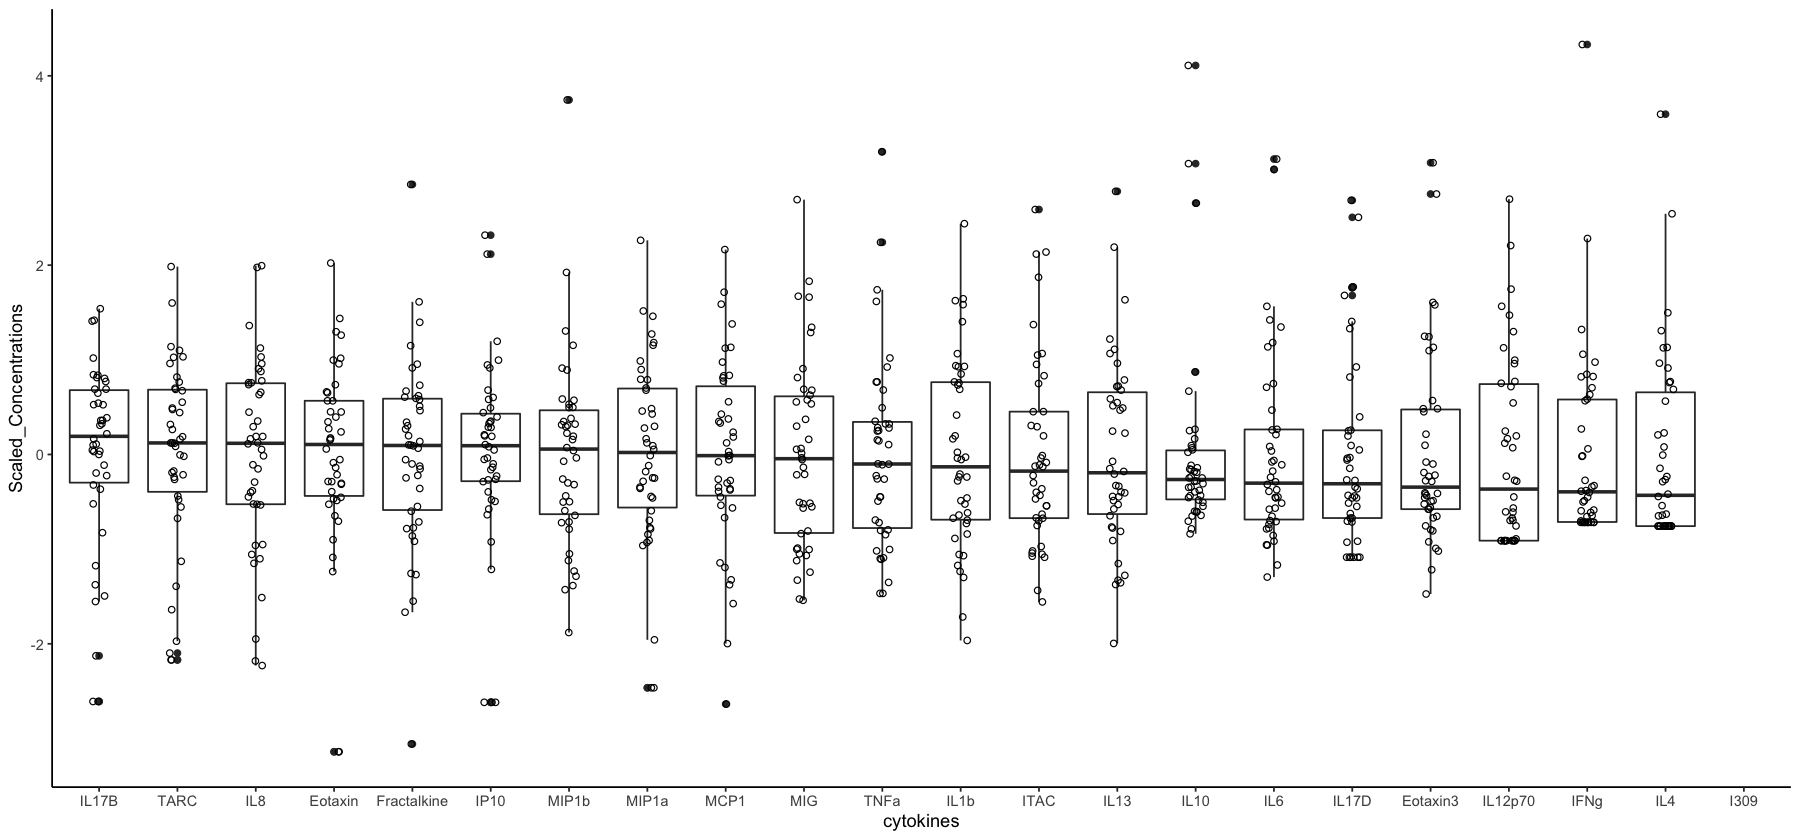

In [39]:
options(repr.plot.width=15, repr.plot.height=7)
#ordering proteins based on median value
arranged_proteins_df = NLF_scaled %>%
    group_by(Protein) %>%
    summarize(median_scaled_concentration = median(Scaled_Concentrations)) %>%
    arrange(-median_scaled_concentration) %>%
    select(Protein)

arranged_proteins = arranged_proteins_df$Protein
cytokines = factor(NLF_scaled$Protein, levels = arranged_proteins) #need to put descending_cytokines into a factor for plotting 
ggplot(NLF_scaled, aes(x = cytokines, y = Scaled_Concentrations)) +
  geom_boxplot() +
  geom_point(cex = 1.5, pch = 1.0,position = position_jitter(w = 0.1, h = 0)) + 
  theme_classic()